<a href="https://colab.research.google.com/github/Shirish2004/EOG_Movement_Classification/blob/main/KNN_Self_Eye_State.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
#reading the data 
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/Datasets_used_for_model/self_eye_state.csv")
from sklearn.utils import shuffle 
data=shuffle(data)
data=data.dropna()
print(data.head(),data.tail(),data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30020 entries, 6872 to 20427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pd_t    30020 non-null  float64
 1   target  30020 non-null  float64
dtypes: float64(2)
memory usage: 703.6 KB
         pd_t  target
6872    50.40     0.0
14686    0.72     1.0
8689   110.86     0.0
8979    13.67     0.0
26305   34.41     0.0          pd_t  target
137   -144.85     0.0
1529    16.33     0.0
28681    0.45     1.0
8004    27.35     0.0
20427   -1.75     1.0 None


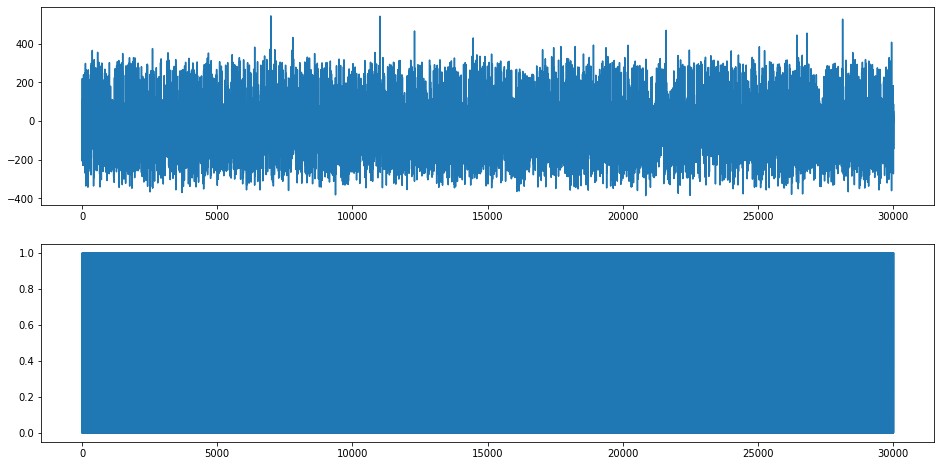

In [3]:
#visualizing the data 
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.figure(figsize=(16,8))
for i in range(data.values.shape[1]):
    plt.subplot(data.values.shape[1],1,i+1)
    plt.plot(data.values[:,i])
plt.show()

In [4]:
data.target.value_counts()
#the count indicates that the data is balanced


0.0    16997
1.0    13023
Name: target, dtype: int64

In [5]:
#Standardising and splitting the data
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler 
import numpy as np 
np.random.seed(32)#to reproduce the results
scaler=StandardScaler()
X=np.array(data.pd_t).reshape(-1,1)
Y=np.array(data.target)
print("Shape of X is ",X.shape,"\n Shape of Y is ",Y.shape)
scaler.fit_transform(X)
print("Data standardised")
#splitting the data
X_train,X_test,Y_train,Y_test=tts(X,Y,test_size=0.2,random_state=32)
print("Data split")

Shape of X is  (30020, 1) 
 Shape of Y is  (30020,)
Data standardised
Data split


**Creating a Baseline Model**

In [6]:
from sklearn.neighbors import KNeighborsClassifier
baseline=KNeighborsClassifier()
#fit the baseline model 
baseline.fit(X_train,Y_train)
print("Model fitted")
score=baseline.score(X_test,Y_test)
print("The accuracy score of baseline model is ",score)


Model fitted
The accuracy score of baseline model is  0.8707528314457028


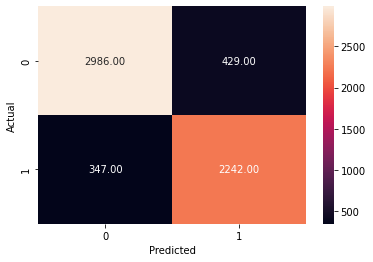

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      3415
         1.0       0.84      0.87      0.85      2589

    accuracy                           0.87      6004
   macro avg       0.87      0.87      0.87      6004
weighted avg       0.87      0.87      0.87      6004



In [7]:
#plotting the confussion matrix and printing the classification report
y_pred=baseline.predict(X_test) 
def confusion_classification(actual,predicted):
  import seaborn as sn 
  from sklearn.metrics import confusion_matrix, classification_report
  cr=classification_report(actual,predicted)
  cm=confusion_matrix(actual,predicted)
  #plotting as heatmap for better visualization 
  sn.heatmap(cm,annot=True,fmt='.2f')
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()
  print(cr)
confusion_classification(Y_test,y_pred)


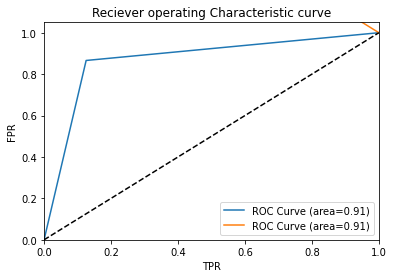

In [8]:
#Drawing the Roc-AUC curve 
'''ROC-AUC curve is one most considerable and trustworthy metric for selecting a model'''
def draw_roc_auc(model,test_X,test_Y):
  from sklearn.metrics import plot_roc_curve, roc_curve,roc_auc_score
  fpr, tpr, thresholds =roc_curve(test_Y,model.predict(test_X))
  auc_score=roc_auc_score(test_Y,model.predict_proba(test_X)[:,1])
  #plotting fpr,tpr and thresholds
  plt.plot(fpr,tpr,thresholds,label="ROC Curve (area=%.2f)"%auc_score)
  #plotting a diagonal line from (0,1)
  plt.plot([0,1],[0,1],'k--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.05])
  plt.ylabel("FPR")
  plt.xlabel("TPR")
  plt.legend(loc="lower right")
  plt.title("Reciever operating Characteristic curve")
  plt.show()
draw_roc_auc(baseline,X_test,Y_test)

It is evident from above results that the model is good with high recall values and alos a good roc_auc_score 
for a model to be selected auc must be >= 0.9 
hence we select this model but we will try to hyper tune it and also perform cross validation in search if we can get a good model.
SInce GridSearchCV of sklearn performs k-fold cross validation 
we would use this method to select the best features 


In [9]:
from sklearn.model_selection import GridSearchCV 
#Create dictionary with list of hyper parameters and range as keys
hyper_parameters=[{'n_neighbors':range(5,10),'weights' : ['uniform','distance'],"metric":['canberra','euclidean','minkowski','manhattan']}]
#executing grid search 
model=GridSearchCV(KNeighborsClassifier(),hyper_parameters,cv=10,scoring='roc_auc')
model.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['canberra', 'euclidean', 'minkowski',
                                     'manhattan'],
                          'n_neighbors': range(5, 10),
                          'weights': ['uniform', 'distance']}],
             scoring='roc_auc')

In [10]:
#getting the model best score ,its best params and grid_scores 
print("The best score of model is ",model.best_score_,"\n The best parameters of model are ",model.best_params_,"\n The grid scores of model are ",model.cv_results_)#earlier cv_results were called grid scores



The best score of model is  0.9232969822317507 
 The best parameters of model are  {'metric': 'canberra', 'n_neighbors': 9, 'weights': 'uniform'} 
 The grid scores of model are  {'mean_fit_time': array([0.01004996, 0.00985882, 0.00960982, 0.00931838, 0.00944269,
       0.00952482, 0.00934923, 0.00967374, 0.00926738, 0.00952342,
       0.00768654, 0.00750134, 0.00760391, 0.00765741, 0.00796418,
       0.00807962, 0.00764582, 0.0076138 , 0.00756564, 0.00756941,
       0.00751684, 0.00781183, 0.00777063, 0.00763831, 0.00747929,
       0.0076369 , 0.00755374, 0.0075531 , 0.00792339, 0.00751376,
       0.00740924, 0.00740185, 0.0074239 , 0.00740273, 0.00782251,
       0.00761571, 0.00759695, 0.00753486, 0.00753059, 0.00730865]), 'std_fit_time': array([1.27074762e-03, 9.42092336e-04, 5.67345574e-04, 2.05881130e-04,
       6.35147759e-04, 2.63092001e-04, 1.50395727e-04, 7.17234015e-04,
       1.17248275e-04, 8.06616639e-04, 7.22421129e-04, 1.71293236e-04,
       1.57120718e-04, 1.53198186e-04

After getting all the scores from above we make model using those best params 

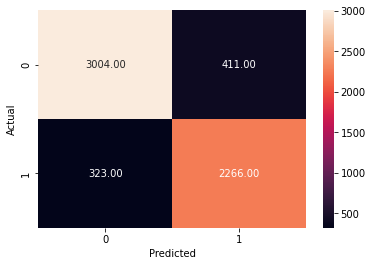

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      3415
         1.0       0.85      0.88      0.86      2589

    accuracy                           0.88      6004
   macro avg       0.87      0.88      0.88      6004
weighted avg       0.88      0.88      0.88      6004



In [11]:
tuned_model= KNeighborsClassifier(n_neighbors = 9, weights = 'uniform',metric = 'euclidean')
tuned_model.fit(X_train, Y_train)
y_pred=tuned_model.predict(X_test)
confusion_classification(Y_test,y_pred)

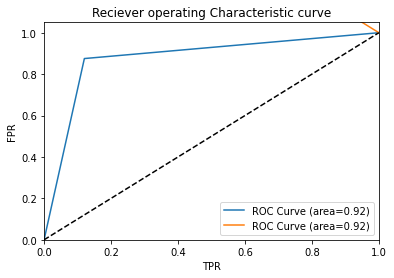

In [12]:
draw_roc_auc(tuned_model,X_test,Y_test)